# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

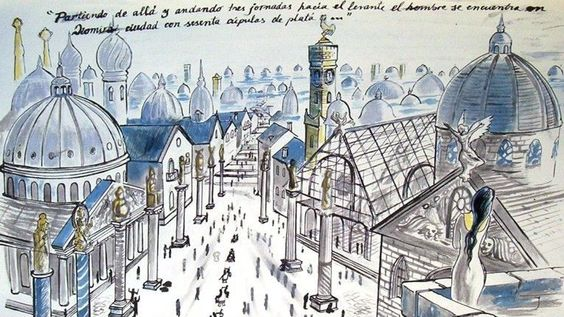

In [5]:
Image(filename='../../Images/Diomira.jpg') 

## DIOMIRA notebook 

DIOMIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

#### Logger

In [15]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

#### Core libraries

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

In [27]:
import nbCoreUtil as cu
import FEParam as FP
import SPE as SP
import FEE2 as FE
from FEE2 import down_scale_signal_
from Nh5 import *
from cities import diomira
from math import *
from system_of_units import *

### Configure

#### This function needs to be defined locally (in the nb) to avoid issues with logger

In [24]:
def cdf_to_dict(cdf):
    """
    transforms the configuration data frame into a dictionary
    """

    dc ={}
    for k in cdf.keys():
        dc[k] = cdf[k][0]
    return dc
    
def configure(cfile, INFO=False, level='INFO'):

    """
    Configures job
    """
    
    lg = 'logging.'+level
    logger.setLevel(eval(lg))

    if cfile == '':
        print("Path to configuration file not given. Please specify path")
        
    cfp =pd.read_csv(cfile,comment="#")
    CFP = cdf_to_dict(cfp)
    
    logger.info("Configuration Parameters (CFP) dictionary  = {}".format(CFP))
    return INFO, CFP
    



### Sensors response

#### Simulate the response of the PMT and the SiPM

*WARNING* The current MCRD comes with a length of 599999 rather than 600000 (0.6 ms) as it should be.

To correct for this in SensorResponse.py we use *rebin_pmt_array(a,stride)* rather than the Util function
*rebin_array(a,stride)*. The difference between them is that *rebin_array* defines the length of the new vector
correctly as *lenb = (len(a))/int(stride)* while *rebin_pmt_array* cheats to handle the bug in MCRD and defines
*lenb = (len(a)+1)/int(stride)*. This will change as soon as MCRD is produced with correct dimensions.

In [18]:

"""
Code
"""

def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation 
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['CO12'] = FP.C12 # to be rewritten by ISIDORA
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC
    
    row.append()
    

def waveform_energy(event_number, sensord):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    rdata = []

    for j in range(sensord.shape[1]):
        swf = sensord[event_number, j]
        ene = np.sum(swf)
        rdata.append(ene)
        
    return np.array(rdata) 

def simulate_sipm_response(event_number,sipmrd_):
    """
    For the moment use a dummy function that simply copies the sipm EARRAY
    """
    rdata = []

    for j in range(sipmrd_.shape[1]):
        rdata.append(sipmrd_[event_number, j])
    return np.array(rdata)


def simulate_pmt_response(event_number,pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns after convoluting with electronics
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 

        #Signal out of DAQ
        signal_daq = fee.daqSignal(signal_fee, noise_rms=0)

        rdata.append(signal_daq)
    return np.array(rdata)

def decimate_signal(event_number,pmtrd_):
    """
    Decimates the MCRD signal to produce TWF (pes, bins 25 ns)
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        twf = down_scale_signal_(pmt, int(FP.time_DAQ))
        
        
        rdata.append(twf)
    return np.array(rdata)

def rebin_pmt_array(a,stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    lenb = (len(a)+1)/int(stride)
    b = np.zeros(lenb)
    j=0
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    return b

def rebin_signal(event_number,pmtrd_):
    """
    rebins the MCRD signal to produce TWF (pes, bins 25 ns)
    """
    
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        twf = rebin_pmt_array(pmt, int(FP.time_DAQ))
        
        rdata.append(twf)
    return np.array(rdata)


#### Driver

DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

In [25]:

def DIOMIRA(cfile, INFO=False, level='INFO'):
    IC, CFP = configure(cfile, INFO=False, level='INFO')
   
    if IC:
        print(diomira)

    FP.print_FEE()
    

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        logger.info("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))

        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",
                           tables.Filters(0))

            # fill table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            # create an extensible array to store the TWF waveforms
            pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

            #create an extensible array to store the energy in PES of PMTs 
            epmt = h5out.create_earray(h5out.root.RD, "epmt", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)

            # create an extensible array to store the energy in PES of SiPMs 
            esipm = h5out.create_earray(h5out.root.RD, "esipm", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NSIPM), 
                                    expectedrows=NEVENTS_DST)

            
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                logger.info("-->event number ={}".format(i))

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response(i,pmtrd_)
                
                #TWF
                 
                truePMT = rebin_signal(i,pmtrd_)
                
                logger.debug("truePMT shape ={}".format(truePMT.shape))
                logger.debug("dataPMT shape ={}".format(dataPMT.shape))
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                
                #TWF for pmts
                pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

                #fill ene_pmt vector
                enePMT = waveform_energy(i, pmtrd_)
                #append to epmt EARRAY
                epmt.append(enePMT.reshape(1, NPMT))

                #fill ene_sipm vector
                eneSIPM = waveform_energy(i, sipmrd_)
                esipm.append(eneSIPM.reshape(1, NSIPM))

            pmtrwf.flush()
            pmttwf.flush()
            sipmrwf.flush()
            epmt.flush()
            esipm.flush()


    print("Leaving Diomira. Safe travels!")


        

### Configuration file

In [32]:
def configure_path(file_name, path):
    """
    returns path+file_name
    """
    return path+'/'+file_name

In [33]:
cf = configure_path('DIOMIRA_NA_ZLIB_test2.csv', '../../Config/')

In [34]:
cf

'../../Config/DIOMIRA_NA_ZLIB_test2.csv'

In [29]:
%less ../../Config/DIOMIRA_NA_ZLIB_test2.csv

####  Running DIOMIRA

In [28]:
DIOMIRA('../../Config/DIOMIRA_NA_ZLIB_test2.csv', INFO=False, level='INFO')

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 100, 'FILE_OUT': 'WF_Na_ZLIB_float32_RWF.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', ' END ': 1, 'CLIB': 'zlib', 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'CLEVEL': 1, 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}

  NEW FEE: DEFAULT PARAMETERS
  PMT gain = 4.5e+06
  sampling time: (fine) =    1.00 ns (DAQ) =   25.00 ns 
  decoupling capacitor =    6.20 nF
  decoupling resistor = 2350.00 ohm
  HPF frequency = 10923.47 Hz  W_HPF_fine = 1.1e-05 W_HPF_daq = 0.00027 
  LPF frequency = 3000000.00 Hz  W_LPF_fine =   0.003 W_LPF_daq =   0.075 
  noise =    0.70 mV
  noise (adc) =    1.79
  vots to adc factor =    2.56 
  
decoupling capacitors for energy plane = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192

### Checking the file

In [30]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test2_RWF.h5'

-rw-r--r--  1 jjgomezcadenas  staff    18M Sep 19 16:12 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test2_RWF.h5


In [44]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test2_RWF.h5', "r+") 

In [45]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test2_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "CO12": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32

In [46]:
pmttwf = h5f.root.RD.pmttwf

In [47]:
pmttwf

/RD/pmttwf (EArray(10, 12, 24000), shuffle, zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 24000)

In [48]:
pmt0 = pmttwf[0,0]

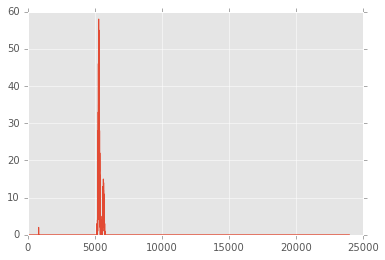

In [49]:
plt.plot(pmt0)

In [50]:
pmtrwf = h5f.root.RD.pmtrwf

In [51]:
pmtr0 = pmtrwf[0,0]

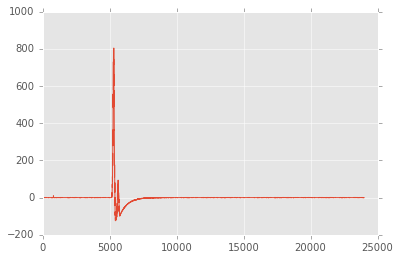

In [52]:
plt.plot(pmtr0)

In [53]:
pmt0_zs = [x for x in pmt0 if x != 0]

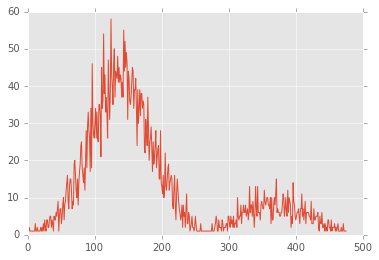

In [54]:
plt.plot(pmt0_zs)

In [55]:
def plts(signal, signal_start=0, signal_end=1e+4, offset=5):

    ax1 = plt.subplot(1,1,1)
    ymin =np.amin(signal[signal_start:signal_end]) - offset
    ymax =np.amax(signal[signal_start:signal_end]) + offset
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([ymin, ymax])
    plt.plot(signal)

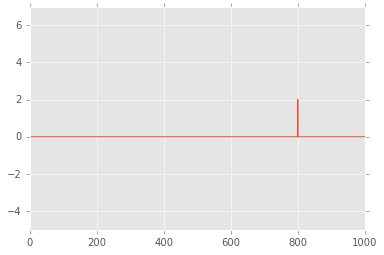

In [56]:
plts(pmt0, signal_start=0, signal_end=1000, offset=5)

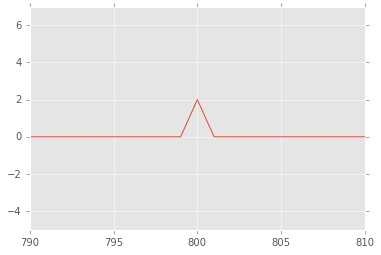

In [57]:
plts(pmt0, signal_start=790, signal_end=810, offset=5)

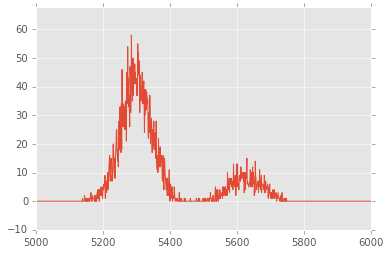

In [58]:
plts(pmt0, signal_start=5000, signal_end=6000, offset=10)

In [59]:
erec = np.sum(pmt0)

In [60]:
erec

5925

In [62]:
epmt = h5f.root.RD.epmt

In [63]:
epmt[0,0]  #energy in pes for event 0 pmt 0

5925

### Plotting waveforms

In [64]:
from PlotUtil import *

In [65]:
def plot_waveforms(pmtwfdf, maxlen=0):
    """
    Takes as input a df storing the PMT wf and plots the 12 PMT WF
    """
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmtwfdf[0])
    
    if maxlen > 0:
        len_pmt = maxlen
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='samples', ylabel='adc')
        plt.plot(pmtwfdf[i])

    
    plt.show()

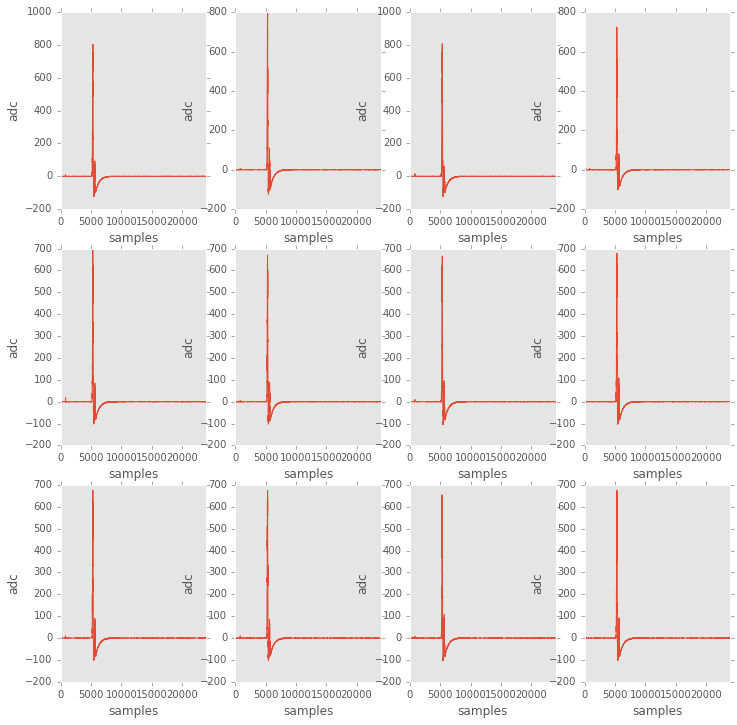

In [66]:
plot_waveforms(pmtrwf[0]) 

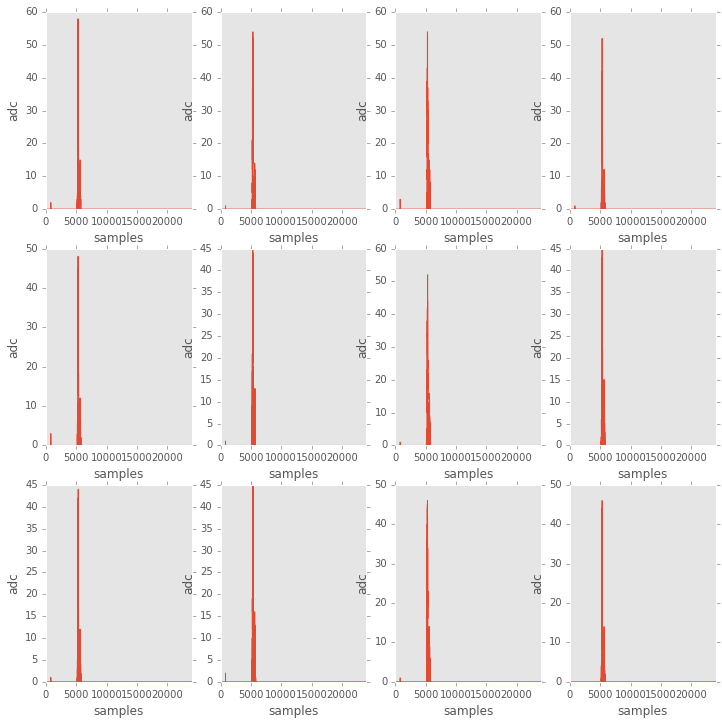

In [67]:
plot_waveforms(pmttwf[0]) 